In [28]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.ndimage import maximum_filter

from astropy import units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
from astropy.modeling.models import Gaussian2D
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.nddata.utils import Cutout2D
from astropy.wcs.utils import pixel_to_skycoord

# Optional: use inline if not working
%matplotlib widget


# SRCNet v0.1 – Smoothing and Resampling Test Case

This notebook serves as a test case for evaluating the SRCNet v0.1 pipeline's ability to smooth and resample multi-frequency 2D maps to a common resolution.

We use real data from the **EMU survey** (ASKAP continuum images) at two frequencies, and apply:

- Convolution with a common elliptical kernel to match resolution (PSF)
- Visualisation of maps and spectral index
- Pixel-based extraction of fluxes and spectral indices
- Region selection tools to define cutouts

In [29]:
# Function to convert FWHM to sigma in pixels
def fwhm_to_sigma(fwhm, pixscale):
    return (fwhm / pixscale) / np.sqrt(8 * np.log(2))

# Function to create 2D elliptical Gaussian kernel
def elliptical_gaussian_kernel(sigma_maj, sigma_min, theta_deg, size=51):
    g = Gaussian2D(1, x_mean=size // 2, y_mean=size // 2,
                   x_stddev=sigma_maj, y_stddev=sigma_min,
                   theta=np.radians(theta_deg))
    y, x = np.mgrid[0:size, 0:size]
    return g(x, y)

# Function to compute convolution kernel from one beam to another
def compute_kernel(from_bmaj, from_bmin, from_bpa, to_bmaj, to_bmin, to_bpa, pixscale):
    sigma_from_maj = fwhm_to_sigma(from_bmaj, pixscale)
    sigma_from_min = fwhm_to_sigma(from_bmin, pixscale)
    sigma_to_maj = fwhm_to_sigma(to_bmaj, pixscale)
    sigma_to_min = fwhm_to_sigma(to_bmin, pixscale)

    sigma_maj = np.sqrt(max(0, sigma_to_maj**2 - sigma_from_maj**2))
    sigma_min = np.sqrt(max(0, sigma_to_min**2 - sigma_from_min**2))

    return elliptical_gaussian_kernel(sigma_maj, sigma_min, to_bpa)

### Data selection

We use data from the ASKAP Pilot Survey for EMU project (AS101)

Go here: https://data.csiro.au/collection/csiro:57194?q=emu&_st=keyword&_str=49&_si=6

And search files matching the below filenames to retrive them. Each files is less than 1GB

In [50]:
# File paths
base_path = "/net/node101/data/users/lofareor/mertens/srcnet/data/swf003-t1"

file1 = base_path + "/image.i.EMU_1554-55_band2.SB40625.cont.taylor.0.restored.fits"
file2 = base_path + "/image.i.EMU_1554-55_band1.SB43773.cont.taylor.0.restored.fits"


### Load FITS images and extract metadata

In this step, we load two EMU continuum images at different frequencies and extract metadata

In [31]:
# Load FITS files
hdul1 = fits.open(file1)
hdul2 = fits.open(file2)

data1 = hdul1[0].data.squeeze()
data2 = hdul2[0].data.squeeze()

header1 = hdul1[0].header
header2 = hdul2[0].header

wcs1 = WCS(header1).celestial
wcs2 = WCS(header2).celestial

# Get the reference frequency (CRVAL along spectral axis)
freq1 = header1['CRVAL3']
freq2 = header2['CRVAL3']

print(f"Frequency 1: {freq1 / 1e6:.1f} MHz")
print(f"Frequency 2: {freq2 / 1e6:.1f} MHz")

# Pixel scale from CDELT1 (assumes square pixels)
pixscale1 = abs(header1['CDELT1']) * u.deg
pixscale2 = abs(header2['CDELT1']) * u.deg

print(f"Pixel scale image 1: {pixscale1.to(u.arcsec):.2f}")
print(f"Pixel scale image 2: {pixscale2.to(u.arcsec):.2f}")

# Beam sizes from BMAJ/BMIN
bmaj1 = header1.get("BMAJ", np.nan) * u.deg
bmin1 = header1.get("BMIN", np.nan) * u.deg
bmaj2 = header2.get("BMAJ", np.nan) * u.deg
bmin2 = header2.get("BMIN", np.nan) * u.deg
bpa1 = header1['BPA']
bpa2 = header2['BPA']

print(f"Beam image 1: BMAJ = {bmaj1.to(u.arcsec):.2f}, BMIN = {bmin1.to(u.arcsec):.2f}")
print(f"Beam image 2: BMAJ = {bmaj2.to(u.arcsec):.2f}, BMIN = {bmin2.to(u.arcsec):.2f}")

# Pointing centres from CRVAL1/CRVAL2
ra1 = header1['CRVAL1']
dec1 = header1['CRVAL2']
ra2 = header2['CRVAL1']
dec2 = header2['CRVAL2']

print(f"Pointing centre image 1: RA = {ra1:.6f} deg, Dec = {dec1:.6f} deg")
print(f"Pointing centre image 2: RA = {ra2:.6f} deg, Dec = {dec2:.6f} deg")


Frequency 1: 1367.5 MHz
Frequency 2: 943.5 MHz
Pixel scale image 1: 2.00 arcsec
Pixel scale image 2: 2.00 arcsec
Beam image 1: BMAJ = 8.55 arcsec, BMIN = 7.50 arcsec
Beam image 2: BMAJ = 12.13 arcsec, BMIN = 10.50 arcsec
Pointing centre image 1: RA = 238.500000 deg, Dec = -55.724836 deg
Pointing centre image 2: RA = 238.500000 deg, Dec = -55.724836 deg


Set OBSGEO-B to   -26.704100 from OBSGEO-[XYZ].
Set OBSGEO-H to      121.995 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


### Visualisation of Full EMU Images

We display the two EMU continuum images side by side.

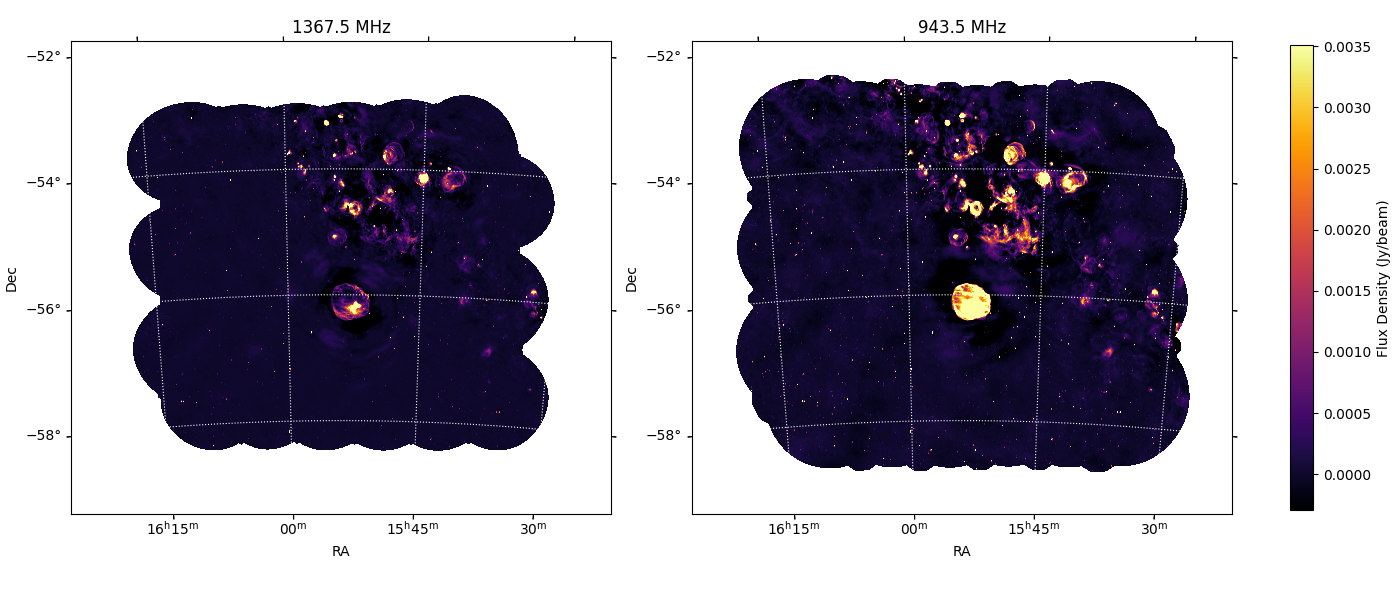

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True, subplot_kw={'projection': wcs1}, layout='constrained')

vmin, vmax = np.nanpercentile(data2, [5, 99])

# Image 1
im1 = axes[0].imshow(data1, origin='lower', cmap='inferno', vmin=vmin, vmax=vmax)
axes[0].set_title(f"{freq1 / 1e6:.1f} MHz")
axes[0].set_xlabel("RA")
axes[0].set_ylabel("Dec")
axes[0].coords.grid(True, color='white', ls='dotted')

# Image 2
im2 = axes[1].imshow(data2, origin='lower', cmap='inferno', vmin=vmin, vmax=vmax)
axes[1].set_title(f"{freq2 / 1e6:.1f} MHz")
axes[1].set_xlabel("RA")
axes[1].set_ylabel("Dec")
axes[1].coords.grid(True, color='white', ls='dotted')

# Shared colorbar
cbar = fig.colorbar(im2, ax=axes, orientation='vertical', shrink=0.85)
cbar.set_label("Flux Density (Jy/beam)")


### Extracting Image Cutouts

We extract cutouts of a set size from both EMU images, centred at a set pixel coordinates.

An (optional) interactactive widget is used to extract center and size of a cutout.

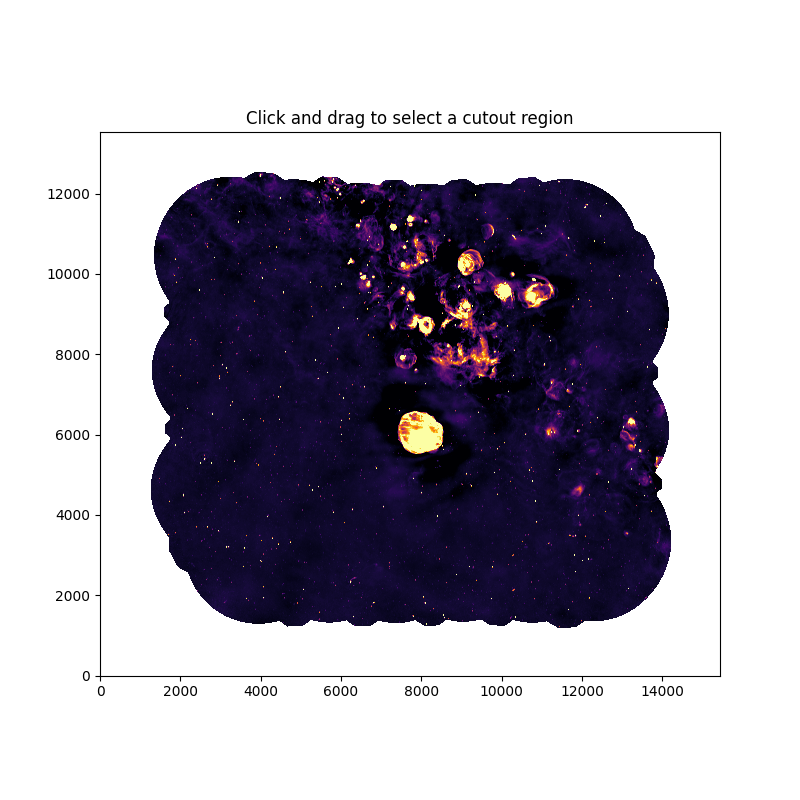

In [41]:
from matplotlib.widgets import RectangleSelector
import matplotlib.pyplot as plt

# Store result
cutout_info = {}

# Callback function
def onselect(eclick, erelease):
    x1, y1 = int(eclick.xdata), int(eclick.ydata)
    x2, y2 = int(erelease.xdata), int(erelease.ydata)
    x_center = (x1 + x2) // 2
    y_center = (y1 + y2) // 2
    width = abs(x2 - x1)
    height = abs(y2 - y1)
    cutout_info['position'] = (x_center, y_center)
    cutout_info['size'] = (width, height)
    title = f"Center: ({x_center}, {y_center}) | Size: ({width}, {height})"
    ax.set_title(title)
    fig.canvas.draw_idle()

# Plot image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(data2, origin='lower', cmap='inferno',
          vmin=np.nanpercentile(data2, 5), vmax=np.nanpercentile(data2, 99))
ax.set_title("Click and drag to select a cutout region")

# RectangleSelector
selector = RectangleSelector(ax, onselect,
                              useblit=True,
                              button=[1],
                              minspanx=5, minspany=5,
                              spancoords='pixels',
                              interactive=True)


In [54]:
from astropy.nddata import Cutout2D

position = (9000, 8000)  # (x, y)
size = (2000, 2000)      # (width, height)

# position = (8000, 6000)  # (x, y)
# size = (1500, 1500)      # (width, height)

# position = (4000, 5000)  # (x, y)
# size = (2000, 2000)      # (width, height)

cutout1 = Cutout2D(data1, position, size, wcs=wcs1)
cutout2 = Cutout2D(data2, position, size, wcs=wcs2)


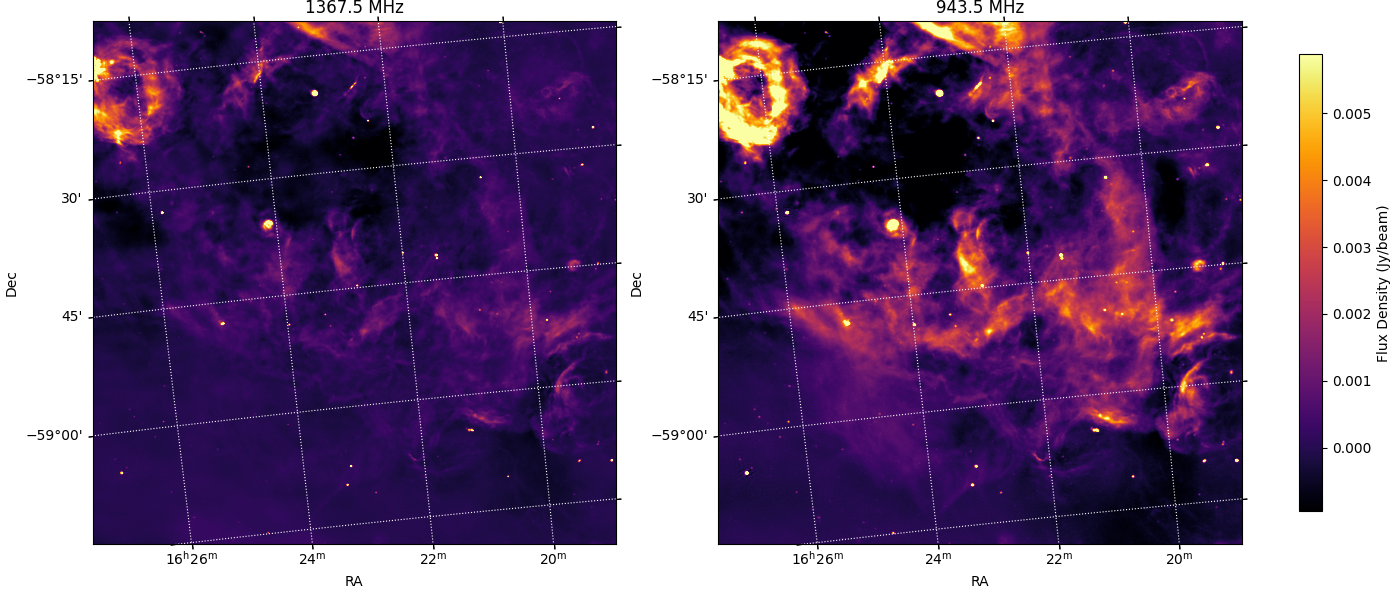

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True, subplot_kw={'projection': wcs1}, layout='constrained')

vmin, vmax = np.nanpercentile(cutout2.data, [5, 99])

# Image 1
im1 = axes[0].imshow(cutout1.data, origin='lower', cmap='inferno', vmin=vmin, vmax=vmax)
axes[0].set_title(f"{freq1 / 1e6:.1f} MHz")
axes[0].set_xlabel("RA")
axes[0].set_ylabel("Dec")
axes[0].coords.grid(True, color='white', ls='dotted')

# Image 2
im2 = axes[1].imshow(cutout2.data, origin='lower', cmap='inferno', vmin=vmin, vmax=vmax)
axes[1].set_title(f"{freq2 / 1e6:.1f} MHz")
axes[1].set_xlabel("RA")
axes[1].set_ylabel("Dec")
axes[1].coords.grid(True, color='white', ls='dotted')

# Shared colorbar
cbar = fig.colorbar(im2, ax=axes, orientation='vertical', shrink=0.85)
cbar.set_label("Flux Density (Jy/beam)")


### Smoothing to a Common Elliptical Beam

To ensure consistent resolution between the two EMU images, we smooth both cutouts using the same elliptical Gaussian kernel. The target beam is defined as:

- **BMAJ / BMIN**: the maximum of the two input beams along each axis
- **BPA**: the average position angle, assuming the beams are similarly oriented


In [56]:
# Determine target beam
target_bmaj = max(bmaj1, bmaj2)
target_bmin = max(bmin1, bmin2)
# Here BPA should be similar between the two maps
target_bpa = np.mean([bpa1, bpa2])

# Pixel scale (deg/pix)
pixscale = abs(header1['CDELT1'])

# Convert FWHM to sigma in pixels
def fwhm_to_sigma(fwhm, pixscale):
    return (fwhm / pixscale) / np.sqrt(8 * np.log(2))

# Create elliptical Gaussian kernel
sigma_maj = fwhm_to_sigma(target_bmaj, pixscale)
sigma_min = fwhm_to_sigma(target_bmin, pixscale)
kernel = elliptical_gaussian_kernel(sigma_maj.value, sigma_min.value, target_bpa, size=51)

# Smooth both cutouts with the same kernel
smooth1 = convolve_fft(cutout1.data, kernel)
smooth2 = convolve_fft(cutout2.data, kernel)

# Print summary
print(f"Applied elliptical Gaussian smoothing:")
print(f"  Target BMAJ = {target_bmaj.to(u.arcsec):.2f}, BMIN = {target_bmin.to(u.arcsec):.2f}, BPA = {target_bpa:.2f}°")
print(f"  Pixel scale = {pixscale * 3600:.2f}\ arcsec/pixel")


Applied elliptical Gaussian smoothing:
  Target BMAJ = 12.13 arcsec, BMIN = 10.50 arcsec, BPA = 84.77°
  Pixel scale = 2.00\ arcsec/pixel


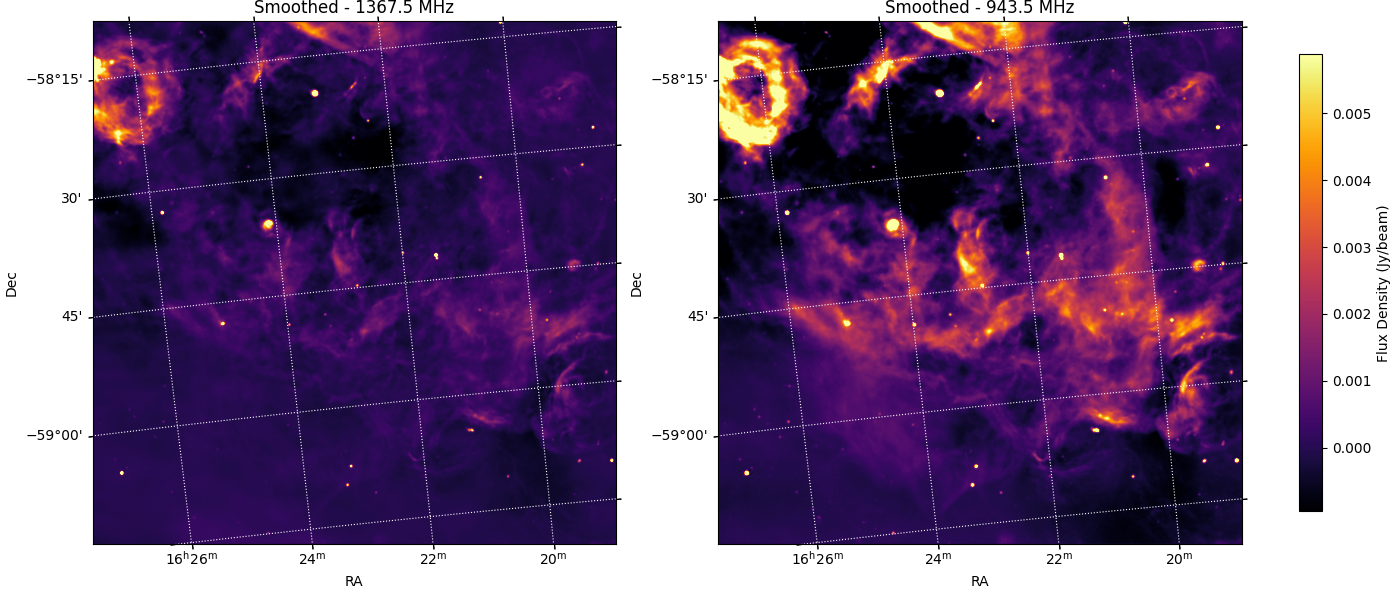

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True, subplot_kw={'projection': wcs1}, layout='constrained')

vmin, vmax = np.nanpercentile(cutout2.data, [5, 99])

# Image 1
im1 = axes[0].imshow(smooth1, origin='lower', cmap='inferno', vmin=vmin, vmax=vmax)
axes[0].set_title(f"Smoothed - {freq1 / 1e6:.1f} MHz")
axes[0].set_xlabel("RA")
axes[0].set_ylabel("Dec")
axes[0].coords.grid(True, color='white', ls='dotted')

# Image 2
im2 = axes[1].imshow(smooth2, origin='lower', cmap='inferno', vmin=vmin, vmax=vmax)
axes[1].set_title(f"Smoothed - {freq2 / 1e6:.1f} MHz")
axes[1].set_xlabel("RA")
axes[1].set_ylabel("Dec")
axes[1].coords.grid(True, color='white', ls='dotted')

# Shared colorbar
cbar = fig.colorbar(im2, ax=axes, orientation='vertical', shrink=0.85)
cbar.set_label("Flux Density (Jy/beam)")


### Spectral Index Map

We compute the spectral index α using the smoothed cutouts at two frequencies with the standard two-point formula:

alpha = log(S2 / S1) / log(nu2 / nu1)

where S1 and S2 are the flux densities at frequencies nu1 and nu2, respectively. To avoid unreliable values, pixels where the second map has flux below 0.2 mJy/beam are masked out.


/tmp/ipykernel_3848397/1477969719.py:2: RuntimeWarning: invalid value encountered in log
  alpha = np.log(smooth2 / smooth1) / np.log(freq2 / freq1)


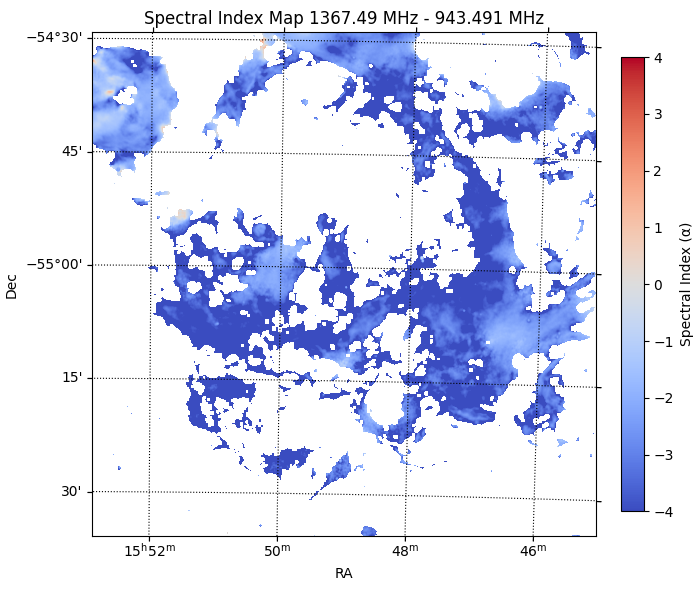

In [58]:
# Compute spectral index map
alpha = np.log(smooth2 / smooth1) / np.log(freq2 / freq1)
alpha[smooth2 < 0.0002] = np.nan  # mask low signal regions

# Plot
fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={'projection': cutout2.wcs}, layout='constrained')

im = ax.imshow(alpha, origin='lower', cmap='coolwarm', vmin=-4, vmax=4)
ax.set_title(f"Spectral Index Map {freq1 * 1e-6} MHz - {freq2 * 1e-6} MHz")
ax.set_xlabel("RA")
ax.set_ylabel("Dec")
ax.coords.grid(True, color='black', ls='dotted')

cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.85)
cbar.set_label("Spectral Index (α)")


### Spectra Index of Brightest Point-like Sources

To identify the brightest compact sources in the cutout, we apply a simple peak-finding method:

- A **maximum filter** is used to locate local maxima within a sliding window of 10×10 pixels.
- From the resulting local peaks, we extract the top 5 brightest sources based on their flux values in the higher-frequency map.

We then extract the corresponding flux values and spectra index


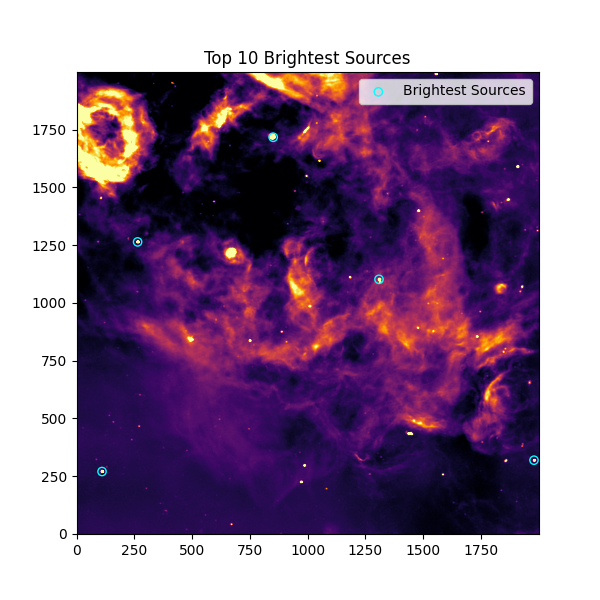

In [59]:
# Parameters
data = cutout2.data
window_size = 10  # roughly beam size in pixels, adjust if needed
n_sources = 5

# Apply maximum filter to find local peaks
local_max = maximum_filter(data, size=window_size) == data

# Mask: valid pixels only (finite and positive)
mask = np.isfinite(data) & (data > 0)

# Combine masks
peaks_mask = local_max & mask

# Get coordinates and values of peaks
y, x = np.where(peaks_mask)
peak_values = data[y, x]
peak_values1 = cutout1.data[y, x]

# Sort by brightness
sorted_indices = np.argsort(peak_values)[::-1]
top_x = x[sorted_indices][:n_sources]
top_y = y[sorted_indices][:n_sources]
top_fluxes = peak_values[sorted_indices][:n_sources]
top_fluxes1 = peak_values1[sorted_indices][:n_sources]

plt.figure(figsize=(6, 6))
plt.imshow(data, origin='lower', cmap='inferno', vmin=np.nanpercentile(data, 5), vmax=np.nanpercentile(data, 99))
plt.scatter(top_x, top_y, marker='o', facecolors='none', edgecolors='cyan', label='Brightest Sources')
plt.legend()
plt.title("Top 10 Brightest Sources")
plt.show()


In [60]:
# Convert pixel coordinates to sky coordinates (RA/Dec)
sky_coords = pixel_to_skycoord(top_x, top_y, cutout2.wcs)

# Extract spectral index values at these positions
top_alphas = alpha[top_y, top_x]

# Print results
print("Top 5 brightest point-like sources:")
for i in range(n_sources):
    ra_str = sky_coords[i].ra.to_string(unit=u.hour, sep=':', precision=2)
    dec_str = sky_coords[i].dec.to_string(unit=u.deg, sep=':', precision=2)
    print(f"{i+1:2d}. RA = {ra_str}, Dec = {dec_str} | "
          f"Flux1 = {top_fluxes1[i]:.3f}, Flux2 = {top_fluxes[i]:.3f} | "
          f"α = {top_alphas[i]:.2f}")


Top 5 brightest point-like sources:
 1. RA = 15:52:27.37, Dec = -55:26:51.21 | Flux1 = 0.090, Flux2 = 0.150 | α = -2.02
 2. RA = 15:51:52.94, Dec = -54:53:41.11 | Flux1 = 0.101, Flux2 = 0.136 | α = -1.72
 3. RA = 15:49:38.49, Dec = -54:38:21.33 | Flux1 = 0.061, Flux2 = 0.107 | α = -1.61
 4. RA = 15:47:49.87, Dec = -54:58:33.89 | Flux1 = 0.113, Flux2 = 0.091 | α = -0.20
 5. RA = 15:45:08.25, Dec = -55:24:03.05 | Flux1 = 0.062, Flux2 = 0.085 | α = -1.79
